In [771]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=100, n_features=2, noise=0, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)



(80, 2) * (2, 10) + (1,) = (80, 10)
(80, 2) * (2, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 2) + (1,) = (80, 2)
(80, 10) * (10, 2) + (1,) = (80, 2)
MeanSquaredError:  4347.497
Keras Accuracy:  7.6435633
Keras Precision:  0.0


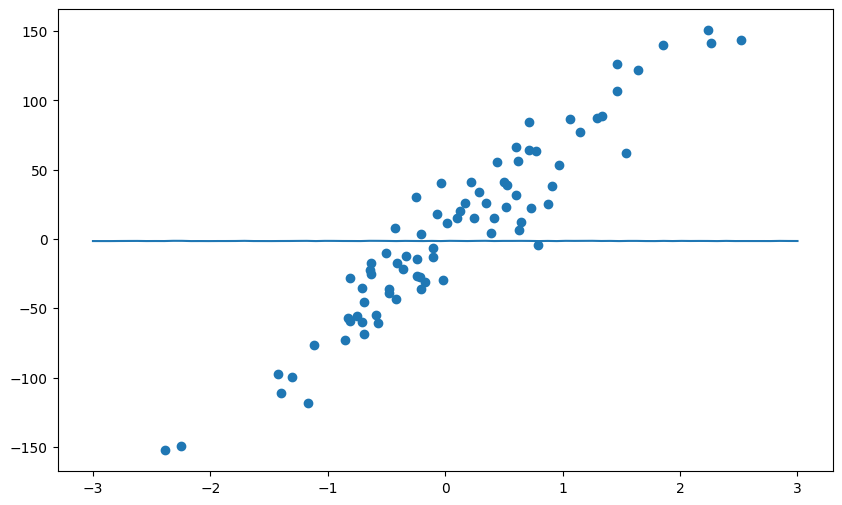

In [778]:
class Layer(tf.Module):
    def __init__(self, neurons=30, activation=tf.identity):
        self.neurons = neurons
        self.activation = activation
        self.build = False
        self.normalized = False

    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    @tf.function
    def __call__(self, X):
        """if self.index == 1:
            z = tf.add(tf.matmul(X, self.weights), self.bias)
            print(z)
        elif self.index > 1:
            z = tf.add(tf.matmul(X, tf.transpose(self.weights)), self.bias)
        elif self.Last:
            z = tf.add(tf.multiply(X, tf.reduce_mean(self.weights, axis=0)), self.bias)
            return self.activation(tf.reduce_mean(z, axis=1))"""

        if not self.build:
            n_features = X.shape[1]
            self.weights = tf.Variable(self.xavier_init(shape=(n_features, self.neurons)), name="Weights", dtype=tf.double, trainable=True )
            self.bias = tf.Variable(tf.zeros(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.matmul(X, self.weights), self.bias)
        print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z)

    

class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, lr=0.001, epochs=10):
        self.layers = layers
        self.epochs = epochs
        self.optimizer = tf.keras.optimizers.Adam(lr)
        self.mse = tf.keras.metrics.MeanSquaredError()
        self.accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.precision = tf.keras.metrics.Precision()

    def load_data(self, X, y):
        self.X = X 
        self.XN = normalize_dataset(X)
        self.y = y

    @tf.function(reduce_retracing=True)
    def accuracy_rrsse(self, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, self.y))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(self.y), predicted)))))
            )), predicted.shape[0]
        )

    @tf.function(reduce_retracing=True)
    def loss(self, predicted):
        return tf.losses.mean_squared_error(self.y, tf.reduce_mean(predicted, axis=1))

    @tf.function
    def calc_metrics(self):
        self.acc_rrsse = self.accuracy_rrsse(self.y_pred)
        self.accuracy.update_state(self.y, self.y_pred)
        self.precision.update_state(self.y, self.y_pred)
        self.mse.update_state(self.y, self.y_pred)

    @tf.function
    def train_step(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def train(self):
        self.y_pred = self.XN
        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.y_pred = model.train_step(self.y_pred)
                loss = self.loss(self.y_pred)
            self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]
            grads = self.optimizer.minimize(loss, self.vars, tape=tape) 
            #self.predicted = self.train_step(self.XN)
        self.y_pred = tf.reduce_mean(self.y_pred, axis=1)
        bias = self.layers[len(self.layers)-1].bias

model = MLPLinearRegressor([
    Layer(neurons=10, activation=tf.nn.relu,),
    Layer(neurons=10, activation=tf.nn.relu,),
    Layer(neurons=10, activation=tf.nn.relu,),
    Layer(neurons=10, activation=tf.nn.relu,),
    Layer(neurons=2,)
], lr=0.1, epochs=10)


model.load_data(X_train2, tf.squeeze(y_train2))
model.train()
model.calc_metrics()


print("MeanSquaredError: ", model.mse.result().numpy())
print("Keras Accuracy: ", model.accuracy.result().numpy())
print("Keras Precision: ", model.precision.result().numpy())


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train2[:, 0], y_train2[:])
ax.plot(np.linspace(-3, 3, num=model.y_pred.shape[0]), model.y_pred[:])
plt.show()

